### outlier removing through local and global filtering, multitemporal data smoothing.

In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt


In [2]:
lake_name = 'dianchi'  
path_ht_spavar = f'data/{lake_name}-lake/swot-pixc/raster_height_spavar.nc'
path_lake_vec = f'data/{lake_name}-lake/hydrolake_{lake_name}_edit.gpkg'
dir_pixc = f'data/{lake_name}-lake/swot-pixc'
paths_pixc_filtered = sorted(glob(dir_pixc + '/*masked_filtered.nc'))  # Get the first .nc file in the directory


In [32]:
## read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec) 
# ## read geoid correction file
raster_ht_spavar = xr.open_dataset(path_ht_spavar) 
pixc_ht_filtered = xr.open_dataset(paths_pixc_filtered[3])  # Read the first .nc file in the directory
pixc_ht_filtered 


<xarray.Dataset> Size: 10MB
Dimensions:           (points: 260788)
Coordinates:
    latitude          (points) float64 2MB ...
    longitude         (points) float64 2MB ...
Dimensions without coordinates: points
Data variables:
    geoid             (points) float32 1MB ...
    height            (points) float32 1MB ...
    ht_ortho          (points) float32 1MB ...
    ht_ortho_filter1  (points) float32 1MB ...
    ht_ortho_filter2  (points) float32 1MB ...
    ht_valid_ids      (points) bool 261kB ...
Attributes:
    date:     2024-04-19

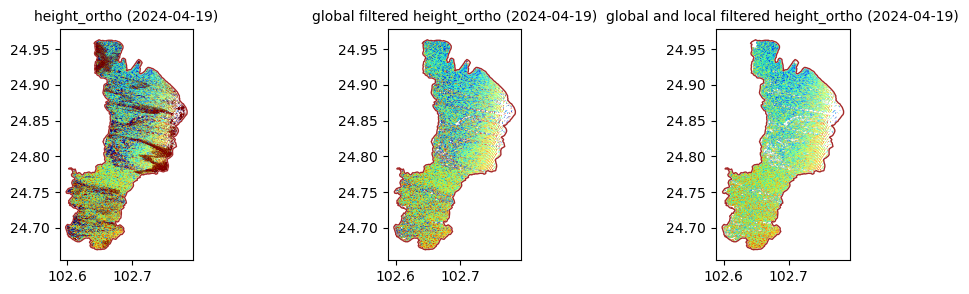

In [33]:
ht_median = np.nanmedian(pixc_ht_filtered['ht_ortho_filter2'])
hts = [pixc_ht_filtered['ht_ortho'], 
           pixc_ht_filtered['ht_ortho_filter1'], 
           pixc_ht_filtered['ht_ortho_filter2']]
ax_title = ['height_ortho', 
              'global filtered height_ortho', 
              'global and local filtered height_ortho']
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for i in range(3):
  scat1 = ax[i].scatter(x=pixc_ht_filtered.longitude, 
                            y=pixc_ht_filtered.latitude, 
                            c=hts[i], s=0.1, 
                            vmin=ht_median-0.3, vmax=ht_median+0.3,
                            edgecolor='none', cmap='jet')
  lake_gdf.plot(ax=ax[i], edgecolor='Brown', facecolor='none', linewidth=1)
  ax[i].set_title(f'{ax_title[i]} ({pixc_ht_filtered.attrs["date"]})', fontsize=10)


In [34]:
def mad_std(x, axis=None):
    """
    Robust std.dev using median absolute deviation
    """
    return 1.4826 * np.nanmedian(np.abs(x - np.nanmedian(x, axis)), axis)


In [35]:
ht_ortho_median = np.nanmedian(pixc_ht_filtered['ht_ortho'].values)
ht_ortho_filter1_median = np.nanmedian(pixc_ht_filtered['ht_ortho_filter1'].values)
ht_ortho_filter2_median = np.nanmedian(pixc_ht_filtered['ht_ortho_filter2'].values)
print(f'median of ht_ortho: {ht_ortho_median:.4f}, \
        \nmedian of ht_ortho_filter1: {ht_ortho_filter1_median:.4f}, \
        \nmedian of ht_ortho_filter2: {ht_ortho_filter2_median:.4f}')
print(end='\n')
ht_ortho_std = mad_std(pixc_ht_filtered['ht_ortho'].values)
ht_ortho_filter1_std = mad_std(pixc_ht_filtered['ht_ortho_filter1'].values)
ht_ortho_filter2_std = mad_std(pixc_ht_filtered['ht_ortho_filter2'].values)
print(f'std of ht_ortho: {ht_ortho_std:.4f}, \
        \nstd of ht_ortho_filter1: {ht_ortho_filter1_std:.4f}, \
        \nstd of ht_ortho_filter2: {ht_ortho_filter2_std:.4f}')


median of ht_ortho: 1887.6653,         
median of ht_ortho_filter1: 1887.5808,         
median of ht_ortho_filter2: 1887.5811

std of ht_ortho: 0.2992,         
std of ht_ortho_filter1: 0.1290,         
std of ht_ortho_filter2: 0.1122


Text(0.5, 1.0, 'dianchi')

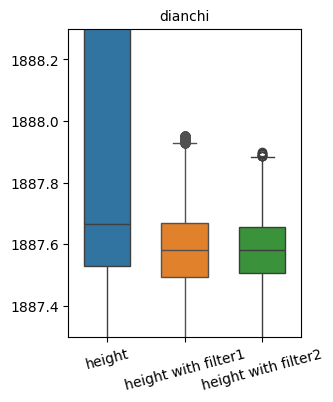

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(3, 4))
# for i in range(8):
boxplot = sns.boxplot(x=0, y=pixc_ht_filtered['ht_ortho'].values, width=0.6, ax=ax)
boxplot = sns.boxplot(x=1, y=pixc_ht_filtered['ht_ortho_filter1'].values, width=0.6, ax=ax)
boxplot = sns.boxplot(x=2, y=pixc_ht_filtered['ht_ortho_filter2'].values, width=0.6, ax=ax)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['height', 'height with filter1', 'height with filter2'], rotation=15)
# ax.set_ylim(6.8, 8)
ax.set_ylim(1887.3, 1888.3)
# ax.set_ylim(4293.6, 4294.85)
# ax.set_ylim(544.2, 546)
# ax.set_ylim(4547.6, 4548.9)
ax.set_title(f'{lake_name}', fontsize=10)



Text(0.5, 1.0, 'Height Distribution')

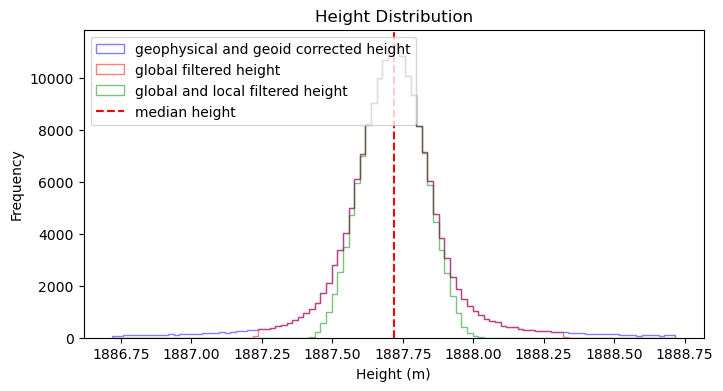

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(pixc_ht_filtered['ht_ortho'], bins=100, color='blue', 
            range=(ht_median-1, ht_median+1),histtype='step',
            alpha=0.5, label='geophysical and geoid corrected height');
ax.hist(pixc_ht_filtered['ht_ortho_filter1'], bins=100, color='red', 
            range=(ht_median-1, ht_median+1), histtype='step',
            alpha=0.5, label='global filtered height');
ax.hist(pixc_ht_filtered['ht_ortho_filter2'], bins=100, color='green', 
            range=(ht_median-1, ht_median+1), histtype='step',
            alpha=0.5, label='global and local filtered height');
ax.axvline(ht_median, color='red', linestyle='--', label='median height');
ax.legend(fontsize=10, loc ='upper left')
ax.set_xlabel('Height (m)')
ax.set_ylabel('Frequency')
ax.set_title('Height Distribution')
